# ADA - Final notebook

This notebook contains all the code which has been used to generate the plots and figures of our [datastory](https://antoineweber.github.io/ADA_Project_RobAda/).

As a summary, our goal was to investigate the potential difference between organic/bio products and regular ones, based on the [Open Food Facts](https://ch-en.openfoodfacts.org/data) dataset.

**TODO:** Add table of content. (Tkt Lucas avec mon extension jupyter j'ai juste a cliquer un bouton, pas besoin d'écrire 20 lignes a la main)

## Imports

In [97]:
import pickle
import pprint
import time
import sys
import os
import json
import copy
import folium
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns
import statsmodels.formula.api as sm

from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
from math import pi

## Loading the dataset

In [2]:
# Make sure to download the dataset and place it in the data folder
OPEN_FOOD_FACTS_PATH = 'data/en.openfoodfacts.org.products.csv'
ENCODING = 'UTF-8'

chunksize = 100000
tfr = pd.read_csv(OPEN_FOOD_FACTS_PATH, encoding=ENCODING, sep='\t', chunksize=chunksize, iterator=True, low_memory=False)
food_facts_df = pd.concat(tfr, ignore_index=True)
food_facts_df.head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00000000001111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print("There are {} rows, hence products, in the dataset.".format(food_facts_df.shape[0]))
print("There are {} columns, hence fields, in the dataset.".format(food_facts_df.shape[1]))

We have 1067619 rows, hence products, in the dataset.
We have 177 columns, hence fields, in the dataset.


### Available fields <a class="anchor" id="availablefields"></a> 

The dataset description is available [here](https://static.openfoodfacts.org/data/data-fields.txt).

This dataset is provided with a text file describing the different fields. We present a brief overview of the main types of fields:

* field `code` containing the product's code. 
* field `creator` indicating who added the product to the dataset. 
* field `countries` showing where the product is selled. 
* fields that end with `_t` are dates in the UNIX timestamp format (number of seconds since Jan 1st 1970)
* fields that end with `_datetime` are dates in the iso8601 format: yyyy-mm-ddThh:mn:ssZ
* fields that end with `_tags` are comma separated list of tags (e.g. categories_tags is the set of normalized tags computer from the categories field)
* fields that end with a language 2 letter code (e.g. fr for French) is the set of tags in that language
* fields that end with `_100g` correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product
* fields that end with `_serving` correspond to the amount of a nutriment (in g, or kJ for energy) for 1 serving of the product

**TODO:** Add general cleaning part if it is still necessary

## Extracting organic/bio products

The core of our data story depends on how we can actually find which products are organic and which are not.

In this section, we will split the whole dataset in two: regular and organic products. This splitting will be done based on four columns: **TODO continue**

## Categorical analysis

For our analysis, we want to compare organic and regular products in terms of nutrional score, contained additives, nova groups and more. However, as shown in the previous section we have two highly unbalanced classes, as there are much fewer organic products. In addition to this, we don't know if the distribution of product categories is different between the regular and organic data. For instance, it could be possible that for organic products there are much more juices than other types of products.

In order to provide a more rigourous analysis, we will try to split the dataset into different categories, and then perform a comparative analysis in each category

### Determining the categories of products in the dataset

The open food facts dataset contains several columns representing the categories : **TODO: list the columns**. The column that is most present is `categories_en`. It is composed of a set of categories separated by commas. In addition, there are some metadata inside it to specify the language of the keywords, such `en:` and `fr:` for english and french respectively.

Our goal is to find out which categories are actually present in `categories_en`. Then we can find common categories to split the dataset based on keywords. For instance, if we wanted to find all the dairy products, we could look for the keywords `[milk, cheese, yoghurt]` in `categories_en`. 

We can also look for keywords related to the category in the `product_name` column. However, it would be more difficult to obtain a reliable splitting. Indeed, if we had a product named `goat milk`, it could be classified in the `meat` category since its name contains `goat`, whereas it's `categories_en` columns would not have `meat` in it. For this reason, we use only the `categories_en` column. **TODO: maybe check with both columns**

In [48]:
# Get the relevant column from the dataset
categories_df = food_facts_df[['categories_en']].dropna().copy()
categories_df.head(5)

,categories_en
3,"Groceries,Condiments,Sauces,Mustards"
4,fr:xsf
10,"Meals,Prepared vegetables,Grated carrots,Seaso..."
17,"Pies,Sweet pies,Coconut pies"
25,"Plant-based foods and beverages,Plant-based fo..."


Our goal is to identify the most common words describing the categories of products across the dataset. 

We use the [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) class to build a bag of words from `categories_en`.

We leverage the arguments of the class to transform all the words to lowercase, ignore stopwords and perform character normalization (remove accents, etc.). In addition, we discard the words that have less than **50** occurences.

In [75]:
def strip_accents(words):
    """ Remove accents in a list of words. """
    
    # If words is [], None or similar
    if not words:
        return words 
    
    # We use the CountVectorizer to actually remove accents
    vectorizer = CountVectorizer(lowercase=False, strip_accents='ascii')
    vectorizer.fit_transform(words)
    
    return vectorizer.get_feature_names()

# We use the stopwords from nltk
from nltk.corpus import stopwords

# We need french+english stopwords as there are both languages in the column
stop_words = stopwords.words('english')
stop_words.extend(strip_accents(stopwords.words('french')))

# This label is present in the column to signify french categories
stop_words.append('fr')

# Remove dupplicates if any
stop_words = list(set(stop_words))

min_occurences = 50

vectorizer = CountVectorizer(stop_words=stop_words, lowercase=True, 
                             strip_accents='ascii', min_df=min_occurences)

bag = vectorizer.fit_transform(categories_df['categories_en'].values)
bag_features = vectorizer.get_feature_names()
print('There are {} different words in total.'.format(len(bag_features)))
print('Keywords:', bag_features[:10]) 

There are 1721 different words in total.
Keywords: ['10', '12', '18', '2000', '2012', '2013', 'ab', 'abbey', 'abondance', 'abricot']


Let's find out the most common words:

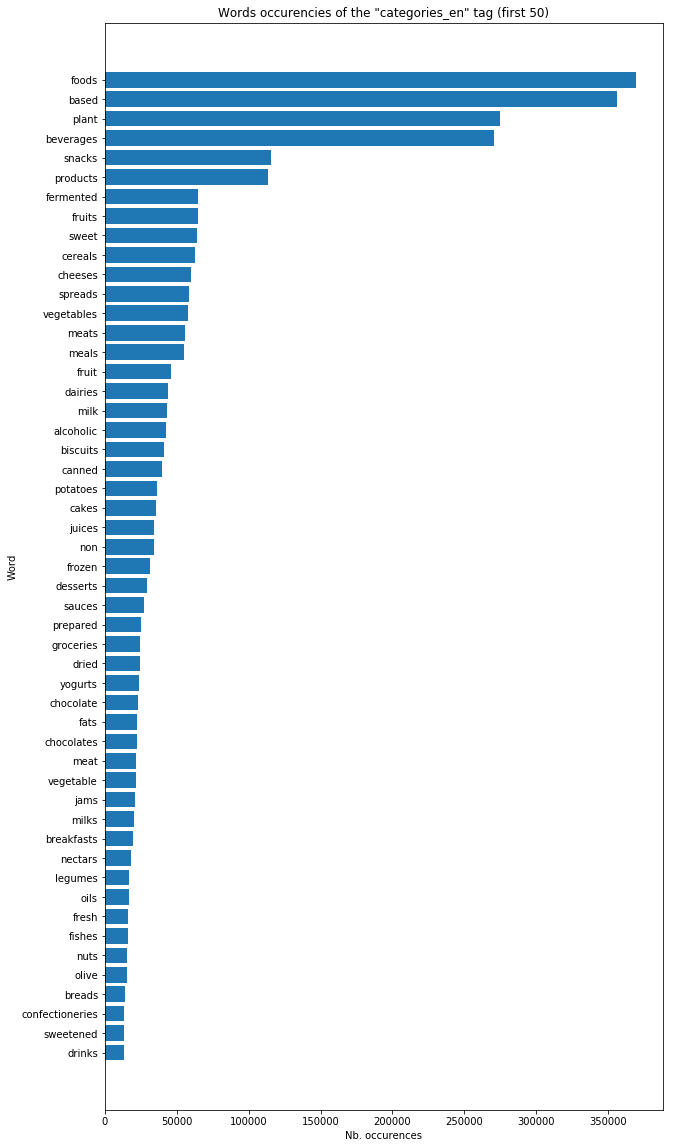

In [34]:
# Sum along the columns to get the total number of occurencies of each token
words_occurences = np.array(bag.sum(axis=0))[0]

# Build a dataframe with the words occurencies
words_occurencies_df = pd.DataFrame({'word':bag_features,'count':words_occurences}).sort_values(by=['count'],ascending=False)\
                            .reset_index().drop(columns='index')

# Plot the most common words
n = 50
plt.figure(figsize=(10,20))
plt.barh(words_occurencies_df.loc[0:n]['word'].values[::-1],
         words_occurencies_df.loc[0:n]['count'].values[::-1])
plt.title('Words occurencies of the "categories_en" tag (first {})'.format(n))
plt.ylabel('Word')
plt.xlabel('Nb. occurences')
plt.show()

There is a good list of words that can be used for categories, although some of them are too general, for instance the most common ones which are `foods` and `based`.

Let's clean the column `categories_en` using the same pre-processing and stop-words removal as before:

In [53]:
preprocessor = vectorizer.build_preprocessor()
tokenizer = vectorizer.build_tokenizer()

categories_df['categories_en'] = categories_df['categories_en'].apply(preprocessor).apply(tokenizer)\
                                    .apply(lambda words: ' '.join([w for w in words if w not in stop_words]))
categories_df.head(5)

,categories_en
3,groceries condiments sauces mustards
4,xsf
10,meals prepared vegetables grated carrots seaso...
17,pies sweet pies coconut pies
25,plant based foods beverages plant based foods ...


We can now define a function that can be used to obtain the product that belong to a specific category defined by keywords:

In [56]:
def find_products_from_category(raw_df, pre_processed_df, category_keywords):
    """ Obtain the products that fall in a given category.
    
    A product belong to a category if its column `categories_en` contain
    one of the category_keywords.
    
    Args:
        raw_df: raw Open Food Facts dataframe to be able to fetch all the products information
        pre_processed_df: datframe where the columns `categories_en` have been
                          cleaned of stopwords, case, accents, etc.
        category_keywords: List of keywords to find in `categories_en`. Note that since the
                           pre_processed_df is a clean string, there is no need to include
                           variations such as `cheese` and `cheeses`, a common step is enough.
        
    Return:
        The products that belong to the categories, with all the info from raw_df
    
    """
    
    products = pre_processed_df[pre_processed_df['categories_en'].apply(
                lambda x : any(kw in x for kw in category_keywords))]
    
    return raw_df.loc[products.index]

For instance let's obtain the dairy products:

In [60]:
dairy_kw = ['dairies','milk','cheese']
dairy_df = find_products_from_category(food_facts_df, categories_df, category_keywords=dairy_kw)
print('There are {} dairy products.'.format(dairy_df.shape[0]))
dairy_df.head(10)

There are 52320 dairy products.


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
51,0000000005005,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1521663684,2018-03-21T20:21:24Z,1545934272,2018-12-27T18:11:12Z,Abondance,NaN,NaN,...,NaN,14.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
321,0000000491228,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1543690964,2018-12-01T19:02:44Z,1543692731,2018-12-01T19:32:11Z,Entremets Crème Brulée,NaN,20 g,...,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
766,0000405017511,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1551706268,2019-03-04T13:31:08Z,1552159083,2019-03-09T19:18:03Z,Chaource lait cru,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1008,0000939333330,http://world-en.openfoodfacts.org/product/0000...,emoups,1569696676,2019-09-28T18:51:16Z,1569697074,2019-09-28T18:57:54Z,creme fraiche,NaN,"213g, 7.5OZ",...,NaN,14.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1084,00011747,http://world-en.openfoodfacts.org/product/0001...,teolemon,1424634361,2015-02-22T19:46:01Z,1561464979,2019-06-25T12:16:19Z,Triple Belgian Chocolaté Chunk Cookies,NaN,225 g e,...,NaN,23.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1093,0001200001217,http://world-en.openfoodfacts.org/product/0001...,date-limite-app,1534008219,2018-08-11T17:23:39Z,1545929001,2018-12-27T16:43:21Z,comte,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1121,00013029,http://world-en.openfoodfacts.org/product/0001...,beniben,1494672859,2017-05-13T10:54:19Z,1494674596,2017-05-13T11:23:16Z,Cheddar,Cheddar en tranches,"7.788 kg (6 * 1,298 kg)",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1226,0002000000707,http://world-en.openfoodfacts.org/product/0002...,kiliweb,1536492887,2018-09-09T11:34:47Z,1569853724,2019-09-30T14:28:44Z,Camenbert de Normandie,NaN,NaN,...,NaN,16.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1227,0002000000714,http://world-en.openfoodfacts.org/product/0002...,kiliweb,1518439760,2018-02-12T12:49:20Z,1552560002,2019-03-14T10:40:02Z,Yaourt nature brebis,NaN,NaN,...,NaN,-3.0,-3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1243,0002000001698,http://world-en.openfoodfacts.org/product/0002...,kiliweb,1549132328,2019-02-02T18:32:08Z,1552569293,2019-03-14T13:14:53Z,Yaourt au lait de brebis bio Nature,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Choice of categories

There are several possible choice of categories in which we can split the products. For instance, the products could be selected and grouped based on their type, following the food pyramid:

<img src="Food_pyramid.gif">

However, this splitting would yield highly unbalanced categories, and we would not produce granular categories.

Instead, we decided to choose a set of categories and sub-categories drawing inspiration from the [Ciqual dataset](https://www.data.gouv.fr/en/datasets/table-de-composition-nutritionnelle-des-aliments-ciqual/) that we investigated during milestone 2. The food products are separated in 3 levels of categories, and we produced the following categories based on it. As we have products in english as well as in french, we provide the french translation of the subcategory to search as well in this languages.

In [95]:
categories = \
{
    'meat, fish, egg':
    {
        'meat': 'viande',
        'fish': 'poisson',
        'egg': 'oeuf',
    },
    
    # TODO: check : Not enough data in openfoodfact from fresh products as there is mostly processed food
    'fruit, vegetable':
    {
        'fruit': 'fruit',
        'vegetable': 'legume',
        'legume': 'Legumineuse',
        'seed': 'graine',
    },
    
    'cereal': # Cereal-based products
    {
        'pasta': 'pate',
        'rice': 'riz',
        'flour': 'farine',
        'bread': 'pain',
        'biscuit': 'biscuit',
        #'cereals': 'cereales' # Breakfast
    },
    
    'drink':
    {
        'water': 'eau',
        'juice': 'jus',
        'soda': 'boisson gazeuse',
        'alcohol': 'alcool',
    },
    
    'dairy':
    {
        'milk': 'lait',
        'cheese': 'fromage',
        'yoghurt': 'yaourt',
        'cream': 'creme',
    },
    
    'cooking ingredient':
    {
        'salsa': 'sauce',
        'spice': 'epice',
        'salt': 'sel',
        'herb': 'herbe',
        'condiment': 'condiment',
    },
    
    'fat':
    {
        'oil': 'huile',
        'butter': 'beurre',
    },
    
    'sugary product':
    {
        'sugar': 'sucre',
        'jam': 'confiture',
        'candy': 'bonbon',
        'chocolate': 'chocolat',
        'ice cream': 'glace',
    },
}

We have quite a few categories, but we now need to find keywords associated to each of them. We could create this list manually but this can prove to be quite tedious and time-consuming. Instead we will harness the power of web-scraping to get such lists automatically.

### Web scraping the category keywords

Wikipedia has pages that list food by categories, but the formatting not homogenous and we would not go faster if we needed to implement a robust scrapping method.

Instead, what we can do is use the name of our categories and find their synonyms using [synonymy](http://www.synonymy.com/synonym.php?word=bob) for instance. For each keywords of categories, we can fetch a list of synonym that we cross-reference with the actual categories in our dataset (obtained previously with CountVectorizer). Finally, we manually filter out the words that are too generic or irrelevant.

We will use BeautifulSoup for web scraping the results.

In [62]:
import requests
from bs4 import BeautifulSoup

Let's define a function to get the webpage associated to the word of which we want to know the synonyms, and fetch the results. We chose this website because it is easy to scrap, and it has also a french version which uses the same HTML layout !

In [68]:
def get_synonyms(word, language='en'):
    """ Fetch the list of synonyms by scrapping the website http://www.synonymy.com, 
    or its French version http://www.synonymes.com (which is exactly the same).
    
    Args:
        word: Word for which to fetch the synonyms
        language: 'en' or 'fr'
        
    Return:
        A list of string which are the synonyms.
    
    """
    BASE_URL_EN = 'http://www.synonymy.com/synonym.php?word={word}'
    BASE_URL_FR = 'http://www.synonymes.com/synonyme.php?mot={word}'
    
    # Build url
    if language == 'en':
        url = BASE_URL_EN.format(word=word)
    elif language == 'fr':
        url = BASE_URL_FR.format(word=word)

    # Get web page for specified word
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    synonyms = []
    
    # The synonyms on this website are in 'div' with class 'defbox'
    for defbox in soup.find_all('div', {'class': 'defbox'}):
        synonyms_links = defbox.find_all('a')
        synonyms.extend([s.text for s in synonyms_links])
        
    # Remove dupplicates
    synonyms = list(set(synonyms))
    
    # Remove empty strings ('')
    synonyms = [s for s in synonyms if s]
    
    # Remove accents
    synonyms = strip_accents(synonyms)
    
    return synonyms

Let's see how it works:

In [72]:
print('english:', get_synonyms('fruit', 'en'))
print('french:', get_synonyms('fruit', 'fr'))

english: ['aftermath', 'capsule', 'effect', 'mature', 'nut', 'outcome', 'pay', 'pod', 'product', 'seed']
french: ['agrume', 'avantage', 'baie', 'benefice', 'conclusion', 'consequence', 'de', 'drupe', 'effet', 'fruits', 'germe', 'graine', 'mer', 'moisson', 'nature', 'pepins', 'produit', 'profit', 'rapport', 'recompense', 'resultat', 'rouges', 'secs']


Now, we have a way to find keywords related to our categories. For each subcategory, we can fetch the synonyms in english and in french. We keep only the synonyms that are present in the list of keywords of categories that we had extracted from the Open Food Facts dataset:

In [98]:
# Build the list of keywords for the sub categories
category_keywords = copy.deepcopy(categories)

for category in categories:
    print(category)
    for english, french in categories[category].items():
        
        # Fetch synonyms
        synonyms = get_synonyms(english, 'en')
        synonyms.extend(get_synonyms(french, 'fr'))
        
        # Remove dupplicates
        synonyms = list(set(synonyms))
        
        # Keep only categories in Open Food Facts
        synonyms = [s for s in synonyms if s in words_occurencies_df.word.values]
        
        # Always include name of sub category
        if french != english:
            synonyms.insert(0, french)
        synonyms.insert(0, english)
        
        category_keywords[category][english] = synonyms
        
        print('\t', english)
        print('\t\t', category_keywords[category][english])

meat, fish, egg
	 meat
		 ['meat', 'viande', 'porc', 'food', 'veau', 'turkey', 'agneau', 'short', 'lean', 'beef', 'chair', 'meal', 'volaille', 'lamb']
	 fish
		 ['fish', 'poisson', 'peche', 'fish', 'poisson', 'seafood']
	 egg
		 ['egg', 'oeuf']
fruit, vegetable
	 fruit
		 ['fruit', 'produit', 'nature', 'seed', 'mer', 'fruits', 'secs', 'rouges', 'nut']
	 vegetable
		 ['vegetable', 'legume', 'plant', 'organic']
	 legume
		 ['legume', 'Legumineuse']
	 seed
		 ['seed', 'graine', 'grain', 'corn', 'plant', 'berry', 'nut']
cereal
	 pasta
		 ['pasta', 'pate', 'vent', 'gateau', 'bloc', 'creme', 'terrine', 'paste', 'foie']
	 rice
		 ['rice', 'riz', 'eau', 'vie', 'riz']
	 flour
		 ['flour', 'farine', 'farine']
	 bread
		 ['bread', 'pain', 'lait', 'grain', 'food', 'petit', 'campagne', 'meals', 'meal', 'pain', 'croute']
	 biscuit
		 ['biscuit']
drink
	 water
		 ['water', 'eau', 'liquid', 'jus', 'ice', 'boisson']
	 juice
		 ['juice', 'jus', 'eau', 'juice', 'jus', 'vie', 'fruit', 'boisson', 'cafe', '

As you can see the keywords are quite good, but there are still a few irrelevant keywords (for instance: `jam` is associated with the words `fix` and `box` which are not synonyms in the case of the food.

There are few keywords so that we can manually edit the results and remove the irrelevant or too generic keywords; we can also add some if we feel like there are some missing.

In [77]:
# Save as json for manual editing
with open('data/category_keywords.json', 'w') as outfile:
    json.dump(category_keywords, outfile, indent=2)

Here is the final version after manual editing:

In [81]:
with open('data/category_keywords_edited.json', 'r') as file:
    category_keywords = json.load(file)

pprint.pprint(category_keywords)

{'cereal': {'biscuit': ['biscuit'],
            'bread': ['bread', 'pain', 'croute'],
            'flour': ['flour', 'farine'],
            'pasta': ['pasta', 'pate'],
            'rice': ['rice', 'riz']},
 'cooking ingredient': {'condiment': ['condiment',
                                      'seasoning',
                                      'flavouring',
                                      'assaisonnement'],
                        'herb': ['herb', 'herbe'],
                        'salsa': ['salsa', 'sauce'],
                        'salt': ['salt', 'sel', 'sodium'],
                        'spice': ['spice',
                                  'epice',
                                  'seasoning',
                                  'assaisonnement',
                                  'zest',
                                  'pepper',
                                  'piment']},
 'dairy': {'cheese': ['cheese', 'fromage'],
           'cream': ['cream', 'creme'],
           'milk': 

With this final list of keywords, we can easily fetch the products that belong to a given sub-category.

### Categorical dataframes

We can now split the data in categories. Please note that the **categories may overlap !** Indeed, we merely search by keywords and do not impose any constraints on the obtained set of products. This is fine as long as we keep this fact in mind.

Let's fill in a dictionary that will contain a dataframe for each subcategory. For the parent categories, we would simply need to merge the children subcategory dataframes.

In [105]:
sub_categories_df_dict = copy.deepcopy(categories)

parent_categories_df_dict = {}

for category in sub_categories_df_dict:
    print(category)
    
    for subcategory in sub_categories_df_dict[category]:
        
        # Get keywords associated to the subcategory
        subcategory_kw = category_keywords[category][subcategory]

        # Get dataframe of products in the subcategory
        sub_categories_df_dict[category][subcategory] = \
                                find_products_from_category(food_facts_df, categories_df, 
                                                            category_keywords=subcategory_kw)
        
        print('\t', subcategory)
        print('\t\t number of products:', sub_categories_df_dict[category][subcategory].shape[0])
    
    parent_categories_df_dict[category] = pd.concat([df for df in sub_categories_df_dict[category].values()])
    print('\t total products:', parent_categories_df_dict[category].shape[0])

meat, fish, egg
	 meat
		 number of products: 234580
	 fish
		 number of products: 18424
	 egg
		 number of products: 6627
	 total products: 259631
fruit, vegetable
	 fruit
		 number of products: 74729
	 vegetable
		 number of products: 122225
	 legume
		 number of products: 8751
	 seed
		 number of products: 126597
	 total products: 332302
cereal
	 pasta
		 number of products: 26008
	 rice
		 number of products: 15968
	 flour
		 number of products: 1876
	 bread
		 number of products: 206451
	 biscuit
		 number of products: 23678
	 total products: 273981
drink
	 water
		 number of products: 34909
	 juice
		 number of products: 86516
	 soda
		 number of products: 12858
	 alcohol
		 number of products: 42840
	 total products: 177123
dairy
	 milk
		 number of products: 53951
	 cheese
		 number of products: 23014
	 yoghurt
		 number of products: 1173
	 cream
		 number of products: 11803
	 total products: 89941
cooking ingredient
	 salsa
		 number of products: 19229
	 spice
		 number of pro

**TODO: remove haha**

**My beloved team members you can now use the dataframe of each sub categories as follows:**

In [109]:
# For a subcategory
sub_categories_df_dict['sugary product']['sugar'].head(5)

# For a parent category
parent_categories_df_dict['sugary product'].head(5)

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
400,0000010206515,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1511122551,2017-11-19T20:15:51Z,1511124271,2017-11-19T20:44:31Z,Pâte à Sucre,Pâte à Sucre - Fondant,250 g,...,NaN,18.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
414,0000010216477,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1530396566,2018-06-30T22:09:26Z,1561464028,2019-06-25T12:00:28Z,Pate a sucre,NaN,NaN,...,NaN,17.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415,0000010216491,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1524386529,2018-04-22T08:42:09Z,1542756116,2018-11-20T23:21:56Z,Pâte à sucre,NaN,NaN,...,NaN,17.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
512,0000030053014,http://world-en.openfoodfacts.org/product/0000...,date-limite-app,1430153513,2015-04-27T16:51:53Z,1543066400,2018-11-24T13:33:20Z,Pastille Vichy,"Bonbon Vichy avec édulcorants, parfum menthe",19 g e,...,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
577,0000069029790,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1524583040,2018-04-24T15:17:20Z,1561464325,2019-06-25T12:05:25Z,Gaufres de Bruxelles,NaN,NaN,...,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
